In [8]:
import pysam
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import itertools
import pandas as pd 
from tabulate import tabulate
import csv
import random

import os
# Change the working directory
os.chdir('/private/home/yxu267/anaconda3/envs/dimelo/lib/python3.10/site-packages')

# Verify the change
print(os.getcwd())



np.set_printoptions(threshold=np.inf)
min_quality_score = 8

#Load the bam file 
bamfile = pysam.AlignmentFile(
    "/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam",
    "rb") 




/private/home/yxu267/anaconda3/envs/dimelo/lib/python3.10/site-packages


[W::hts_idx_load3] The index file is older than the data file: /private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD_mA_mC.bam.csi


In [9]:
input_file = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
CDR_dict = {}
with open(input_file, 'r') as infile:  
    for i in infile:
        chr_num = i.split('\t')[0]
        CDR_start = int (i.split('\t')[1]) 
        CDR_end = int(i.split('\t')[2].split('\n')[0]) 
        if chr_num not in CDR_dict:
            CDR_dict[chr_num] = [[CDR_start ,CDR_end]]
        elif chr_num in CDR_dict:  
            CDR_dict[chr_num].append ([CDR_start ,CDR_end])


In [10]:
def generate_distance_based_dicts(CDR_dict, distance_ranges):
    new_dicts = {}
    for start, end in distance_ranges:
        range_key = f'{start}_to_{end}'
        new_dicts[range_key] = {}
    
    for chr_num, regions in CDR_dict.items():
        # Sort regions based on the start position
        regions.sort()
        for start, end in distance_ranges:
            range_key = f'{start}_to_{end}'
            new_dicts[range_key][chr_num] = []
            for i in range(len(regions) - 1):
                distance = regions[i + 1][0] - regions[i][1]
                if start <= distance <= end:
                    new_dicts[range_key][chr_num].append([regions[i], regions[i + 1]])
            # Remove empty chromosome entries
            if not new_dicts[range_key][chr_num]:
                del new_dicts[range_key][chr_num]
    
    return new_dicts

# Define the distance ranges
distance_ranges = [(0, 5000), (5000, 10000), (10000, 15000), (15000, 20000), (20000, 25000), (25000, 30000), (30000, 35000)]

# Generate the new dictionaries based on the distance ranges
distance_based_dicts = generate_distance_based_dicts(CDR_dict, distance_ranges)


Processing range: 0_to_5000
Processing range: 5000_to_10000
Processing range: 10000_to_15000
Processing range: 15000_to_20000
Processing range: 20000_to_25000
Processing range: 25000_to_30000
Processing range: 30000_to_35000


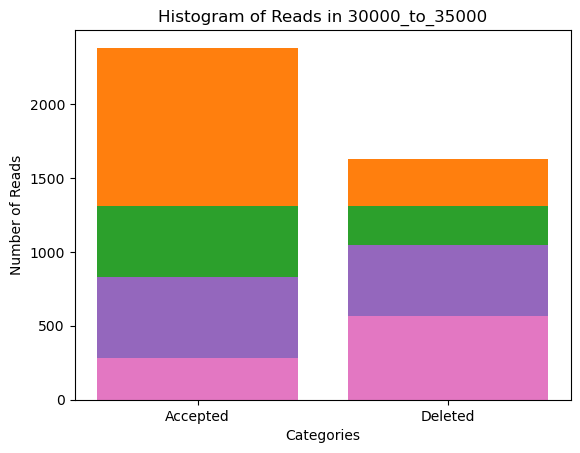

In [11]:
import pysam
import matplotlib.pyplot as plt
import os

# Function to calculate overlap
def calculate_overlap(start1, end1, start2, end2):
    return max(0, min(end1, end2) - max(start1, start2))

# Function to fetch reads that cover at least 70% of the region
def fetch_reads_from_region(bamfile, chrom, start, end, percentage):
    reads = []
    read_names = []
    region_length = end - start
    min_overlap = percentage * region_length
    for read in bamfile.fetch(chrom, start, end):
        read_start = read.reference_start
        read_end = read.reference_end
        overlap = calculate_overlap(start, end, read_start, read_end)
        if overlap >= min_overlap:
            reads.append(read)
            read_names.append(read.query_name)
    return reads, read_names

def read_selection(bamfile, regions_of_interest, output_bam_file_path, histogram_title, bed_file_path):

    # Convert dictionary format regions_of_interest to a list of tuples
    regions_list = []
    for chrom, regions in regions_of_interest.items():
        for region in regions:
            regions_list.append((chrom, region[0], region[1]))

    # Dictionary to store reads and read names for each region
    reads_by_region1 = {}
    read_names_by_region1 = {}
    reads_by_region2 = {}
    read_names_by_region2 = {}

    accepted_reads = []
    deleted_reads = []
    covered_regions = []

    # Iterate over each region and fetch reads and read names
    for chrom, region1, region2 in regions_list:
        start1 = region1[0]
        start2 = region2[0]
        end1 = region1[1]
        end2 = region2[1]

        reads1, read_names1 = fetch_reads_from_region(bamfile, chrom, start1, end1, 0.7)
        reads_by_region1[(chrom, start1, end1)] = reads1
        read_names_by_region1[(chrom, start1, end1)] = read_names1

        reads2, read_names2 = fetch_reads_from_region(bamfile, chrom, start2, end2, 0.7)
        reads_by_region2[(chrom, start2, end2)] = reads2
        read_names_by_region2[(chrom, start2, end2)] = read_names2

        # Compare read names between the two regions and keep common reads
        common_read_names = set(read_names1) & set(read_names2)
        accepted_reads.extend([read for read in reads1 if read.query_name in common_read_names])
        accepted_reads.extend([read for read in reads2 if read.query_name in common_read_names])
        deleted_reads.extend([read for read in reads1 if read.query_name not in common_read_names])
        deleted_reads.extend([read for read in reads2 if read.query_name not in common_read_names])

        # Add covered regions to the list
        covered_regions.append((chrom, start1, end1))
        covered_regions.append((chrom, start2, end2))

    # Save accepted reads to a new BAM file
    with pysam.AlignmentFile(output_bam_file_path, "wb", template=bamfile) as output_bam:
        for read in accepted_reads:
            output_bam.write(read)

    # Save covered regions to a BED file
    with open(bed_file_path, 'w') as bed_file:
        for region in covered_regions:
            bed_file.write(f"{region[0]}\t{region[1]}\t{region[2]}\n")

    # Generate a histogram
    categories = ['Accepted', 'Deleted']
    counts = [len(accepted_reads), len(deleted_reads)]

    plt.bar(categories, counts)
    plt.xlabel('Categories')
    plt.ylabel('Number of Reads')
    plt.title(f'Histogram of Reads in {histogram_title}')
    #plt.show()

output_bam_dir = '/private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/'
os.makedirs(output_bam_dir, exist_ok=True)

for distance_range, dict_regions in distance_based_dicts.items():
    print(f"Processing range: {distance_range}")
    output_bam_file_path = os.path.join(output_bam_dir, f'test_{distance_range}.bam')
    bed_file_path = os.path.join(output_bam_dir, f'test_{distance_range}.bed')
    read_selection(bamfile, dict_regions, output_bam_file_path, distance_range, bed_file_path)

# Close the BAM file after processing
bamfile.close()


In [12]:
import subprocess
import os

# Function to sort and index BAM files using samtools
def sort_and_index_bam(bam_file_path):
    sorted_bam_file_path = bam_file_path.replace('.bam', '_sorted.bam')
    
    # Sort the BAM file
    subprocess.run(['samtools', 'sort', '-o', sorted_bam_file_path, bam_file_path])
    
    # Index the sorted BAM file
    subprocess.run(['samtools', 'index', sorted_bam_file_path])

# Get a list of all generated BAM files
output_bam_dir = '/private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/'
bam_files = [os.path.join(output_bam_dir, f) for f in os.listdir(output_bam_dir) if f.endswith('.bam')]

# Sort and index each BAM file
for bam_file in bam_files:
    sort_and_index_bam(bam_file)
    print(f"Processed {bam_file}")


Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_0_to_5000.bam
Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_30000_to_35000.bam
Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_5000_to_10000.bam
Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_0_to_5000_sorted.bam
Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_5000_to_10000_sorted.bam
Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_20000_to_25000_sorted.bam
Processed /private/groups/migalab/dan/data_analysis/01_09_24_R1041_DiMeLoAdaptive_CENPA/CENPA_AS_target_regions/test_15000_to_20000.bam
Processed /private/groups/migalab/dan/d